# Anomaly Detection Using Banpei Changepoint Probabilities

Reference this [Wiki entry](https://en.wikipedia.org/wiki/Lanczos_algorithm) for information on the Lanczos Algorithm/aproach to changepoint probability processing. Ghosh would probably like to hear us talk a bit about this, so it would be good to fluff up our presentation and blog post a bit with some background. Also reference [Turi documentation](https://turi.com/learn/userguide/anomaly_detection/bayesian_changepoints.html); this would have be awesome and easy to use for anomaly detection before Apple bought Turi and dropped all of their time-series-related packages. It was useful for figuring out how to use changepoints though.

Note that the Banpei algorithm is subject to randomness and idk how to set a seed for it because it's a little black-boxy, so once we determine a model with optimal parameters, we can get the average number of anomalies in a given time period.

### Setup

In [1]:
#!pip install banpei

import banpei
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

random.seed(1234)

train = pd.read_csv('train_predictions.csv')
train.drop('Timestamp',axis=1,inplace=True)
test = pd.read_csv('test_predictions.csv')
test.drop('Timestamp',axis=1,inplace=True)

model = banpei.SST(w=50)
results = model.detect(test['tv delta'], is_lanczos=True)

### A Baseline Model

In [2]:
outlierbin = []
avgprog = [0]
stdprog = [0]
cumcutoff = []

for i in results:
    avgprog.append(i)
    stdprog.append(i)
    cumcutoff.append(np.mean(avgprog)+(2*np.std(stdprog)))
    if np.mean(avgprog)-(2*np.std(stdprog)) <= i <= np.mean(avgprog)+(2*np.std(stdprog)):
        outlierbin.append(0)
    else:
        outlierbin.append(1)

In [3]:
anomalies=[]

def to_xcoords(list):
    xcoords=[]
    csum=0
    for i in list:
        csum+=1
        i = csum*i
        anomalies.append(i)
        
to_xcoords(outlierbin)

In [4]:
#plot a subset of tv delta
def plot_temp(anomalies,results):
    sns.set(rc={'figure.figsize':(20,10)})
    sns.set_style('darkgrid')
    sns.lineplot(data=test['tv delta'][3616:6420],color='green')

    ymins=[]
    ymaxs=[]

    for i in range(len(anomalies)):
        ymins.append(int(test['tv delta'][i]-25))
        ymaxs.append(int(test['tv delta'][i]+25))

    plt.vlines(x=anomalies, ymin=ymins, ymax=ymaxs, colors='red', ls='-', lw=1)

    #add vlines marking summer start (June 20th, 3895) and end (September 22, 6141)
    plt.vlines(x=3895, ymin=0, ymax=350, colors='grey', ls='--', lw=1)
    plt.text(x=3895, y=325, s='  Start of Summer', alpha=1, color='black')

    plt.vlines(x=6141, ymin=0, ymax=350, colors='grey', ls='--', lw=1)
    plt.text(x=6141, y=325, s='  End of Summer', alpha=1, color='black')

    #add vlines marking anomalies
    plt.xlim(3616,6420)
    plt.ylim(0,350)
    plt.title("Anomalies Between June 1st and October 1st, 2016", fontsize=20) #actually goes a lil past oct 1st
    plt.savefig('Summer 2016 Anomalies Using Banpei Changepoints.jpeg', bbox_inches='tight') 
    plt.show()

    #plot changepoint probabilities
    sns.set(rc={'figure.figsize':(20,5)})
    sns.lineplot(data=results)
    sns.lineplot(data=np.asarray(cumcutoff))
    plt.xlim(3616,6420)
    plt.ylim(.00005,1)
    plt.yscale('log')
    plt.title("Banpei Changepoint Probabilities", fontsize=20)
    plt.savefig('Summer 2016 Banpei Changepoint Probabilities.jpeg', bbox_inches='tight') 
    plt.show()
    
    print('\nThis model detects',sum(outlierbin),'anomalies.')

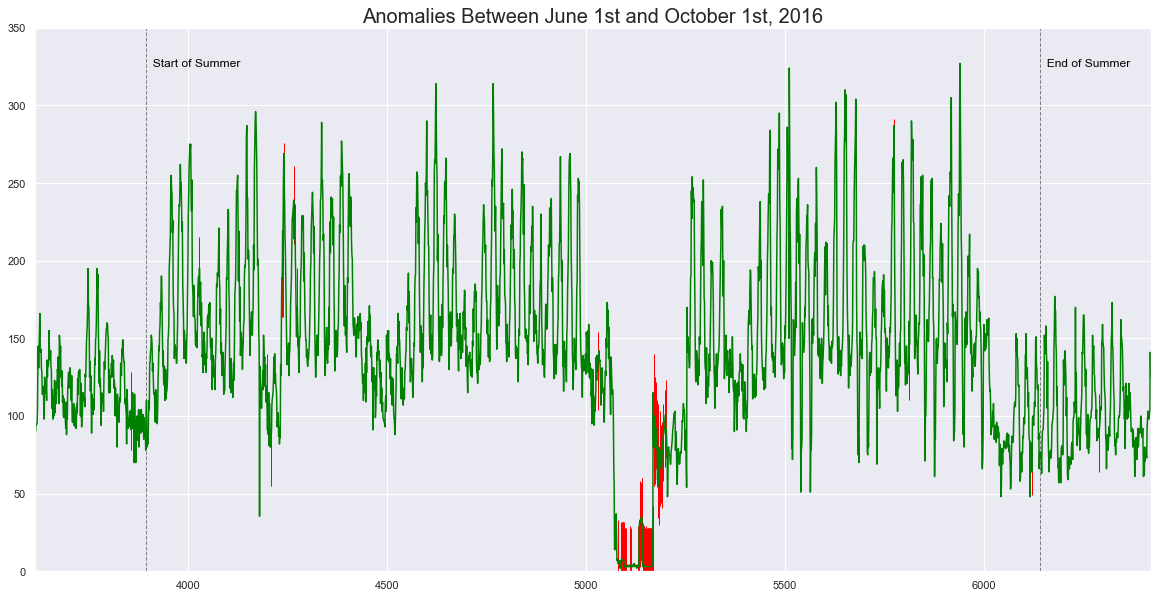

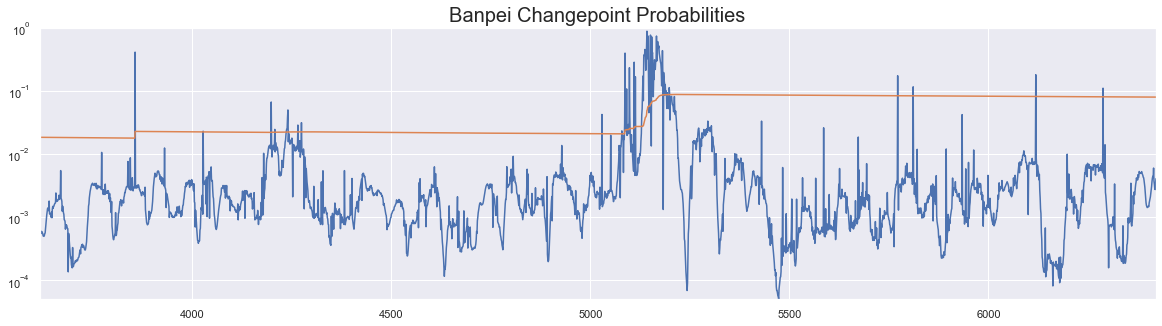


This model detects 176 anomalies.


In [5]:
plot_temp(anomalies,results)

Note a limitation of this baseline model: The cumulative cutoff point (in orange above) may become less sensitive to anomalies over time because it is calculated as the progressive average plus/minus 2 standard deviations. Let's also compare how this graph would look if the cutoff point were only calculated using the last month of data (i.e., more sensitive to change).

### A High-Sensitivity Model Using a Volatile Cutoff Point

In [6]:
outlierbin = []

#calculate moving average for a 24-hour period
avgprog = [0]*24
stdprog = [0]*24
cumcutoff = []

for i in results:
    avgprog.append(i)
    stdprog.append(i)
    cumcutoff.append(np.mean(avgprog)+(2*np.std(stdprog)))
    if np.mean(avgprog)-(2*np.std(stdprog)) <= i <= np.mean(avgprog)+(2*np.std(stdprog)):
        outlierbin.append(0)
    else:
        outlierbin.append(1)
    avgprog.pop(0)
    stdprog.pop(0)
    
anomalies=[]
to_xcoords(outlierbin)

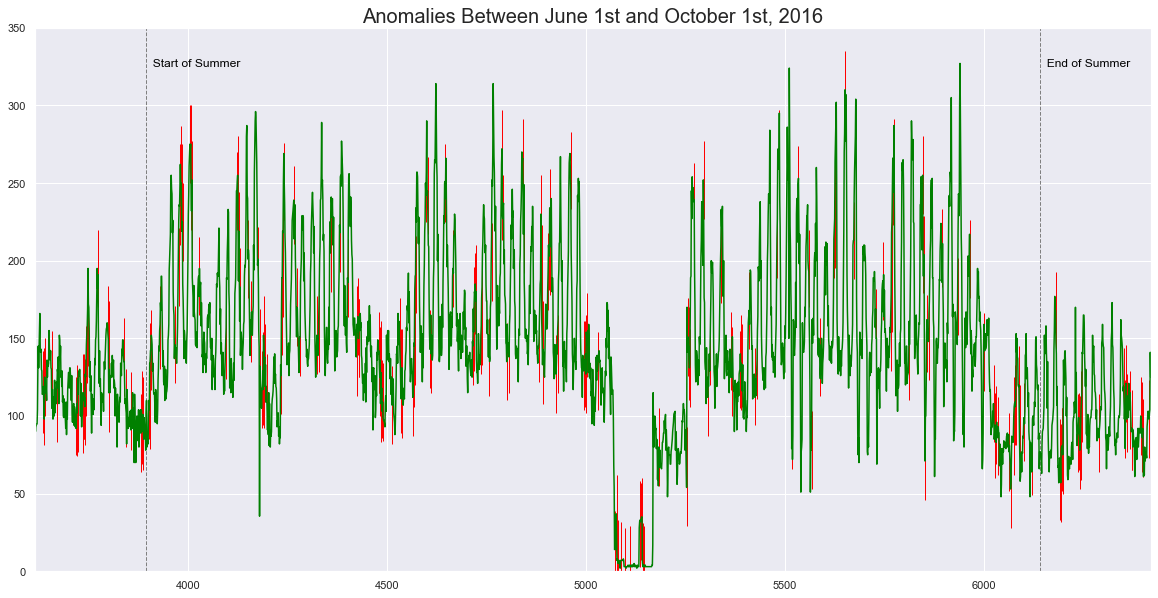

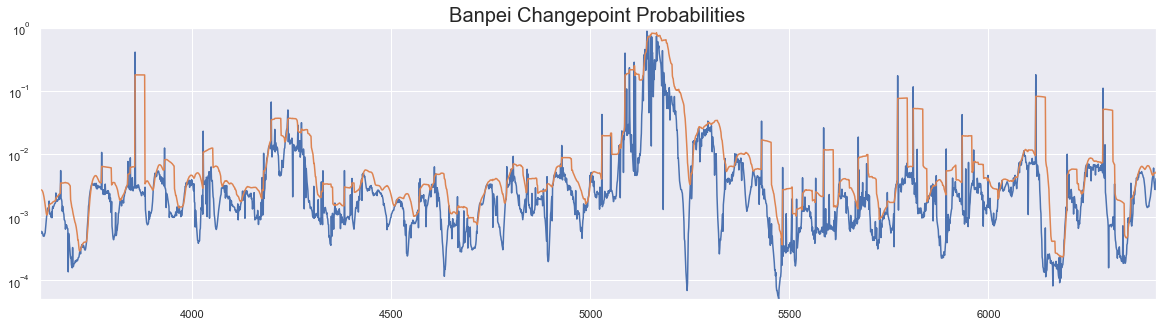


This model detects 2277 anomalies.


In [7]:
plot_temp(anomalies,results)

This starts to look a bit like our PyOD graph which wasn't very useful because of how sensitive it was to changes. To get a better model, we may want to decrease sensitivity while still updating the cutoff point fairly dynamically. This next model calculates the Banpei cutoff using a moving window average over four months.

### Decreasing Sensitivity a Lil Bit

In [8]:
outlierbin = []

#calculate moving average for about a month
avgprog = [0]*31*24
stdprog = [0]*31*24
cumcutoff = []

for i in results:
    avgprog.append(i)
    stdprog.append(i)
    cumcutoff.append(np.mean(avgprog)+(2*np.std(stdprog)))
    if np.mean(avgprog)-(2*np.std(stdprog)) <= i <= np.mean(avgprog)+(2*np.std(stdprog)):
        outlierbin.append(0)
    else:
        outlierbin.append(1)
    avgprog.pop(0)
    stdprog.pop(0)
    
anomalies=[]
to_xcoords(outlierbin)

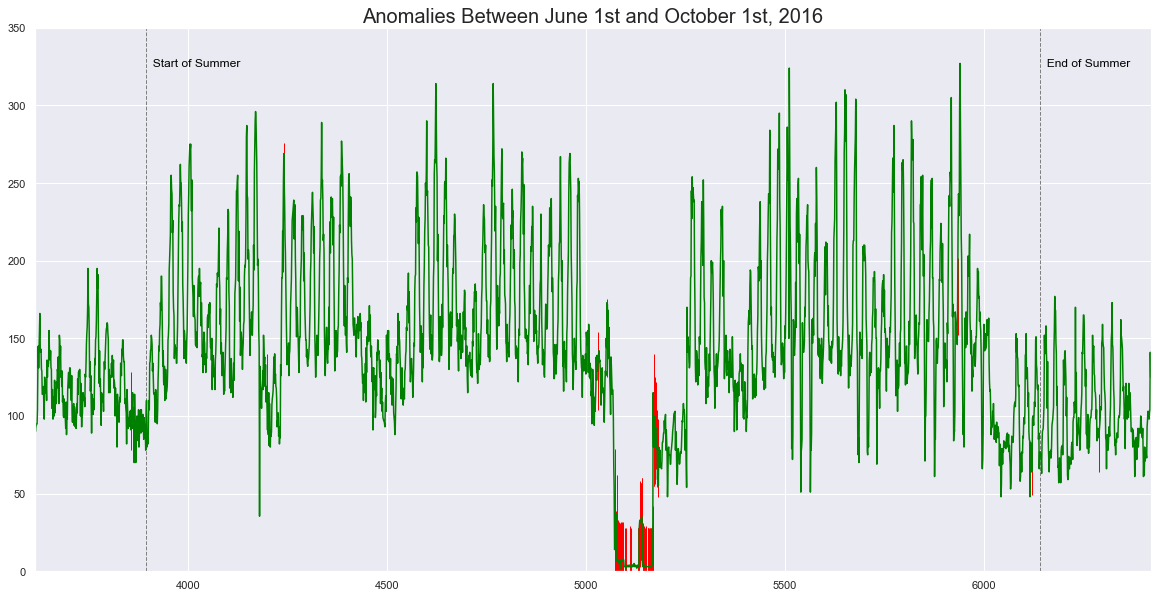

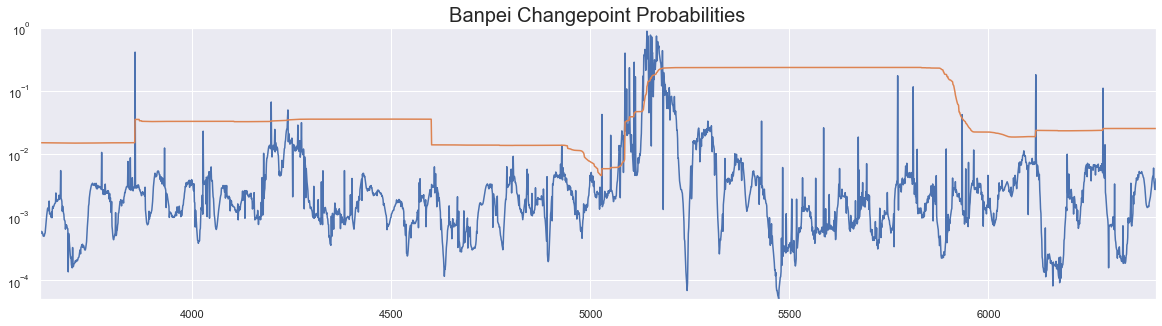


This model detects 429 anomalies.


In [9]:
plot_temp(anomalies,results)

This model seems to be the optimal for anomaly detection. It is superior to the PyOD and high-sensitivity Banpei CPP variant as a detection model because its anomalies are concentrated in areas of high or low power usage relative to the preceding month, as per our moving average window size. This model is also superior to the baseline Banpei CPP which flags outliers based on a global and low-sensitivity cutoff point. We can see how our final model outperforms the baseline by noting the additional anomalies near the end of Summer 2016 that our final model detects and our baseline misses. This is the benefit of having a more dynamic cutoff point (i.e., month-long moving aveage).

Note that few 'missing' anomaly flags in the graph of the final model between x=4500 and x=5000 compared to the baseline model. If we are to accept that our more dynamic cutoff point is a benefit to accuracy, then we can argue that these 'missing' flags are false positives from our baseline model that our final model was sensitive and accurate enough to correctly classify as nominal energy usage levels.

### Further Analysis with Our Optimal Model

In [12]:
'''anomalycounts=[]
for i in range(1,1000):
    outlierbin = []
    avgprog = [0]*31*24
    stdprog = [0]*31*24
    cumcutoff = []
    for i in results[3616:6420]:
        avgprog.append(i)
        stdprog.append(i)
        cumcutoff.append(np.mean(avgprog)+(2*np.std(stdprog)))
        if np.mean(avgprog)-(2*np.std(stdprog)) <= i <= np.mean(avgprog)+(2*np.std(stdprog)):
            outlierbin.append(0)
        else:
            outlierbin.append(1)
        avgprog.pop(0)
        stdprog.pop(0)
    anomalycounts.append(sum(outlierbin))'''

'anomalycounts=[]\nfor i in range(1,1000):\n    outlierbin = []\n    avgprog = [0]*31*24\n    stdprog = [0]*31*24\n    cumcutoff = []\n    for i in results[3616:6420]:\n        avgprog.append(i)\n        stdprog.append(i)\n        cumcutoff.append(np.mean(avgprog)+(2*np.std(stdprog)))\n        if np.mean(avgprog)-(2*np.std(stdprog)) <= i <= np.mean(avgprog)+(2*np.std(stdprog)):\n            outlierbin.append(0)\n        else:\n            outlierbin.append(1)\n        avgprog.pop(0)\n        stdprog.pop(0)\n    anomalycounts.append(sum(outlierbin))'